In [1]:
# import dependencies
# import sys
# !{sys.executable} -m pip install mpl-scatter-density
import matplotlib as mplt
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import glacierml as gl
import numpy as np
import warnings
from tensorflow.python.util import deprecation
import os
import logging
import seaborn as sns
from tqdm import tqdm
from IPython.display import display, HTML
import geopy
from sklearn.cluster import KMeans
from scipy.stats import shapiro
import chart_studio as cs
from matplotlib.ticker import PercentFormatter
from scipy.stats import gaussian_kde
import mpl_scatter_density
from scipy.stats import gaussian_kde
import matplotlib.colors as mcolors
tf.random.set_seed(42)

# display(HTML("<style>.container { width:85% !important; }</style>"))
tf.get_logger().setLevel(logging.ERROR)
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
deprecation._PRINT_DEPRECATION_WARNINGS = False
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
pd.set_option('display.max_columns', None)

pd.set_option('mode.chained_assignment', None)

RS = range(0,25,1)

print('currently running tensorflow version: ' + tf.__version__)

currently running tensorflow version: 2.8.0


# ML Analysis

In [7]:
parameterization = '4'
if parameterization == '1':
    threshold = 'No Threshold'
if parameterization == '2':
    threshold = '0.25'
if parameterization == '3':
    threshold = '0.50'
if parameterization == '4':
    threshold = '0.75'
dataset = gl.parameterize_data(parameterization)
dataset

,CenLat,CenLon,Slope,Zmin,Zmed,Zmax,Area,Aspect,Lmax,Thickness
0,63.469173,-146.528168,12.0,722,1841,3081,234.583,30,41911,235.0
9,51.177000,-116.330000,15.3,2390,2526,2853,0.872,69,1181,70.0
13,44.164970,-121.784960,17.6,2221,2544,2803,1.170,344,1666,19.0
14,44.106820,-121.759380,20.4,2394,2612,2925,1.184,47,1391,17.0
15,44.107470,-121.783660,20.8,2297,2567,2857,0.557,318,1471,21.0
...,...,...,...,...,...,...,...,...,...,...
483,-33.403600,-69.822000,10.0,4255,5492,5885,7.233,298,8109,122.0
485,-33.222300,-70.205600,21.1,3469,4970,5364,5.374,88,4739,38.0
489,-33.029600,-70.098400,29.0,2929,5121,5894,8.376,358,8560,59.0
492,-28.381400,-69.609100,11.6,5068,5406,5753,5.209,79,3782,67.0


In [40]:
# load deviations table 
rootdir = 'zults/'
predictions = pd.DataFrame()
statistics = pd.DataFrame()
file_reader = pd.read_csv(rootdir + 'model_statistics_' + parameterization + '.csv')
statistics = pd.concat([statistics, file_reader], ignore_index = True)

statistics = statistics.drop('Unnamed: 0', axis = 1)
statistics['total parameters'] = statistics['total parameters'].astype(int)
statistics['trained parameters'] = statistics['trained parameters'].astype(int)
statistics['total inputs'] = statistics['total inputs'].astype(int)
statistics['test - train'] = (
    abs(statistics['test mae avg'] - statistics['train mae avg']))
statistics['paramater ratio'] = statistics['trained parameters'] / statistics['total inputs']
statistics

,layer architecture,total parameters,trained parameters,total inputs,test mae avg,train mae avg,test mae std dev,train mae std dev,architecture weight 1,architecture weight 2,test - train,paramater ratio
0,3-2,60,41,3069,17.888150,18.320922,4.794239,3.915898,145.110860,0.006891,0.432772,0.013359
1,4-2,72,53,3069,19.495260,19.487580,5.440397,4.502279,133.148514,0.007510,0.007680,0.017269
2,5-2,84,65,3069,16.948900,17.207373,4.296981,3.105293,153.152412,0.006529,0.258473,0.021180
3,6-2,96,77,3069,17.472450,17.441128,5.753468,3.278046,148.563301,0.006731,0.031322,0.025090
4,7-2,108,89,3069,18.054400,18.706029,4.467628,4.463059,143.774640,0.006955,0.651629,0.029000
...,...,...,...,...,...,...,...,...,...,...,...,...
156,16-15,450,431,3069,15.679167,16.010148,3.222594,0.768343,165.555028,0.006040,0.330981,0.140437
157,17-15,475,456,3069,15.743689,16.066999,3.108120,0.780996,164.876527,0.006065,0.323310,0.148583
158,18-15,500,481,3069,15.769674,16.090924,3.054389,0.852239,164.604852,0.006075,0.321250,0.156729
159,19-15,525,506,3069,15.665721,16.042760,3.150946,0.752430,165.697122,0.006035,0.377039,0.164875


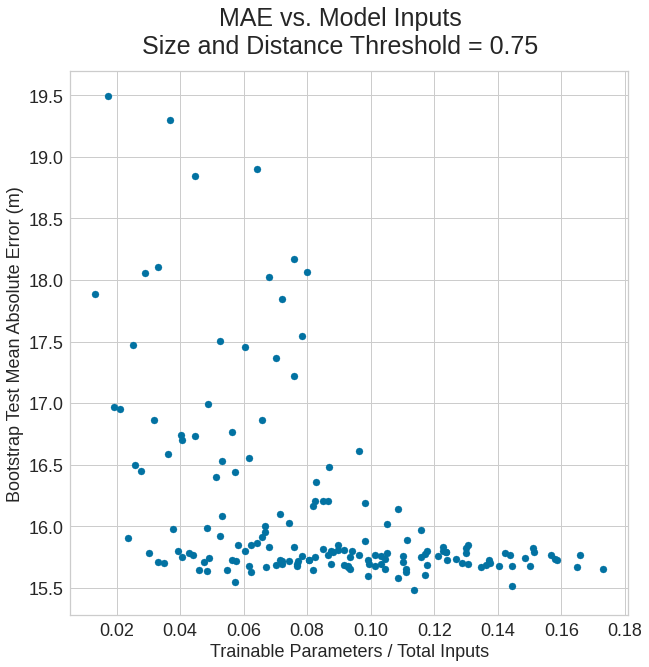

In [41]:
fig = plt.figure(figsize=(10,10))
plt.subplots_adjust(hspace=0.5)
plt.suptitle('MAE vs. Model Inputs\n'+
             'Size and Distance Threshold = ' + threshold, fontsize = 25, y=.97
            )
fig.patch.set_facecolor('w')
plt.scatter(
    statistics['paramater ratio'],
    statistics['test mae avg']
)
# plt.xscale('log')
plt.ylabel('Bootstrap Test Mean Absolute Error (m)', fontsize = 18)
plt.xlabel('Trainable Parameters / Total Inputs', fontsize = 18)
plt.yticks(fontsize = 18)
plt.xticks(fontsize = 18)
plt.show()
# plt.savefig('figs/elbow/75.png')

3-2


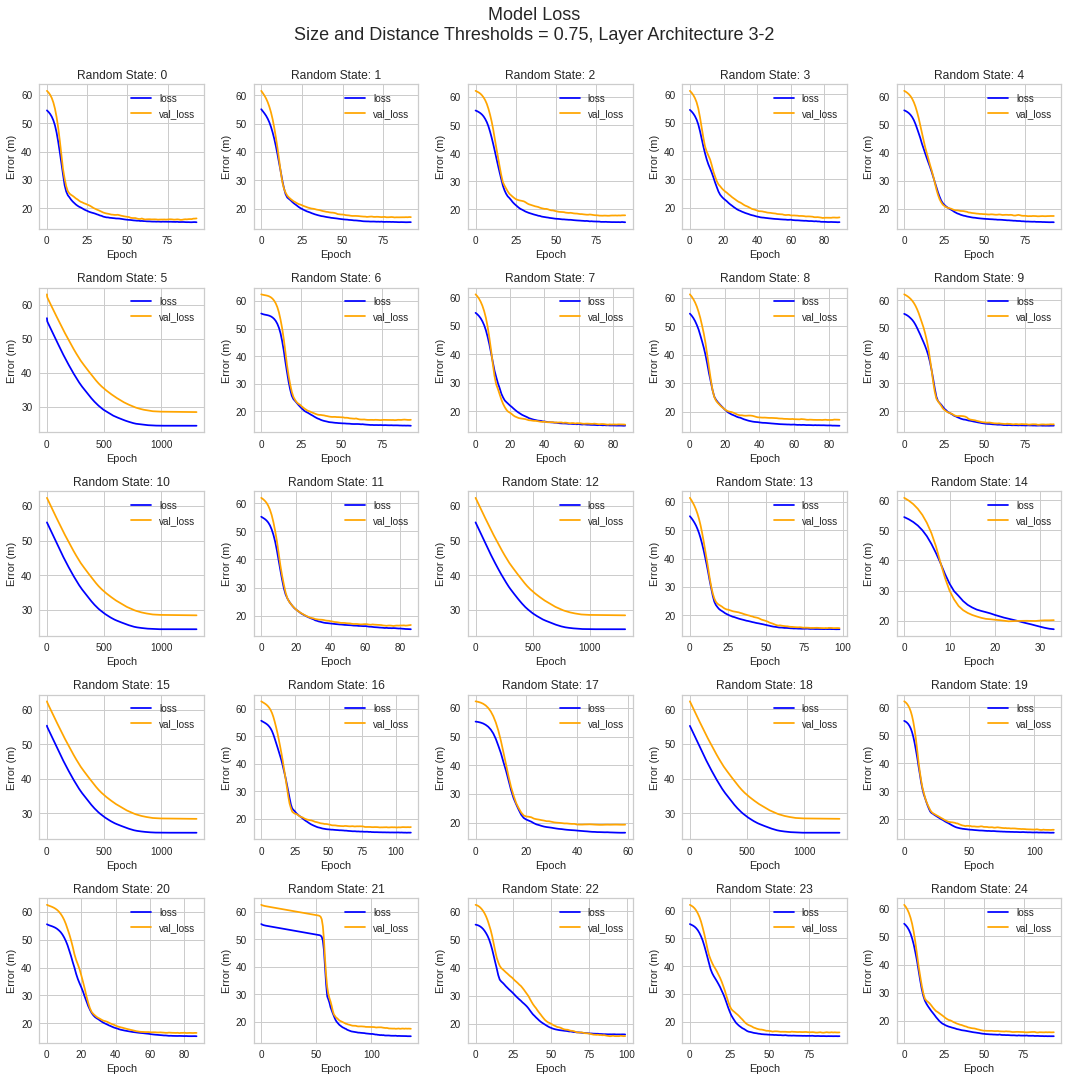

In [45]:
# load selected model and look at predicted accuracies of each random state
# print('Please select index from statistics table to inspect further')

# selection = int(input())
selection = 0
arch = statistics['layer architecture'].loc[selection]


print(arch)

rootdir_1 = 'saved_results/' + parameterization + '/' + arch + '/'
# print(rootdir_1)
dnn_history = {}
fig,ax=plt.subplots(1,1,figsize=(15,15))
fig.patch.set_facecolor('w')
plt.suptitle(
    'Model Loss\nSize and Distance Thresholds = ' + threshold +
    ', Layer Architecture ' + arch , fontsize=18, y=1
            )


for n, rs in enumerate(RS): 
    ax = plt.subplot(5,5,n+1)
    history_name = (

        str(rs)
    )

    model_name = (

        str(rs)
    )

    dnn_history[model_name] = pd.read_csv(rootdir_1 + model_name)

    ax.set_title('Random State: ' + str(rs))
#     if abs((
#         dnn_history[model_name]['loss'].iloc[-1]
#     ) - dnn_history[model_name]['val_loss'].iloc[-1]) >= 3:
#         pass
#     else:
    gl.plot_loss(dnn_history[model_name])
plt.tight_layout()

25it [00:07,  3.48it/s]


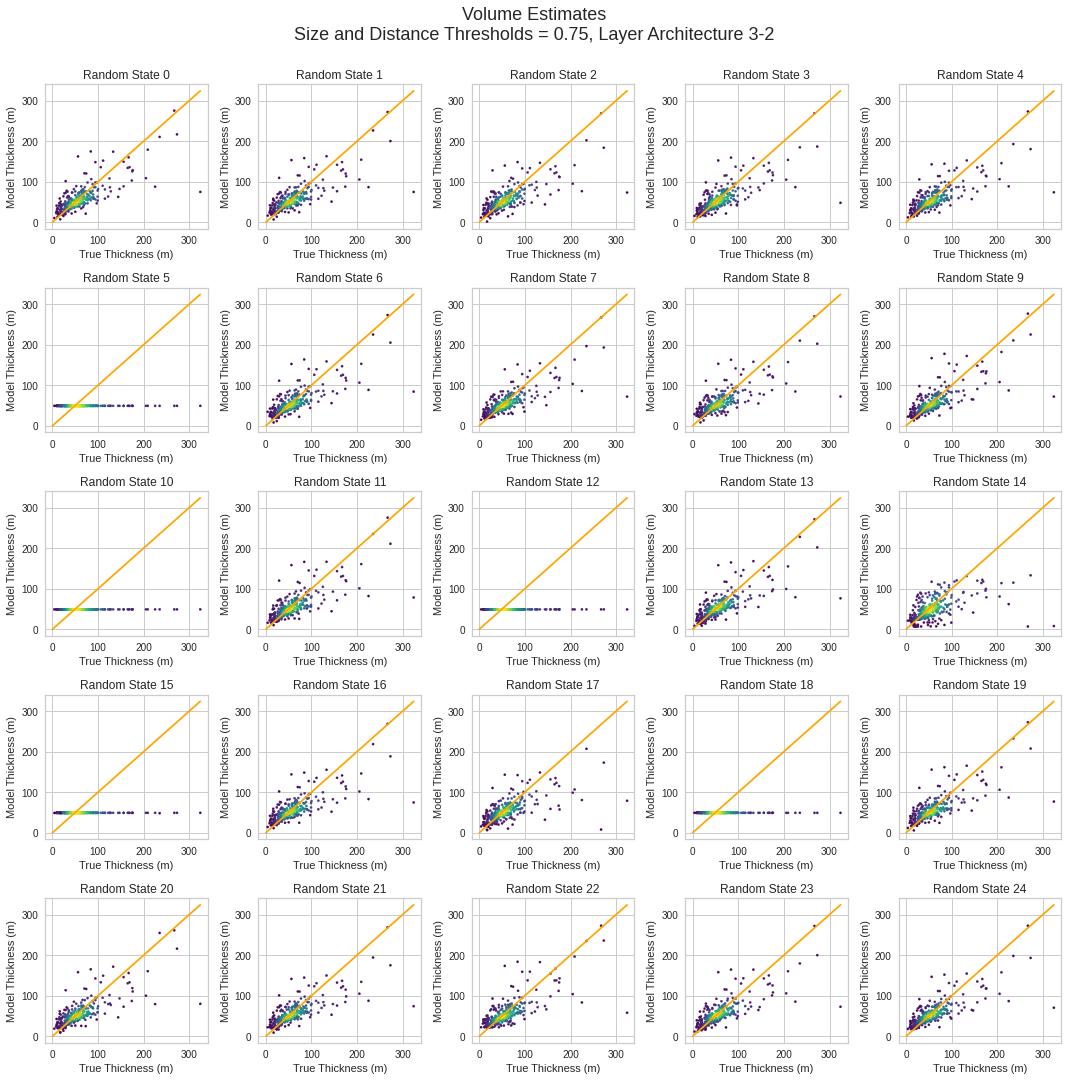

In [47]:

dnn_model = {}
rootdir_2 = 'saved_models/' + parameterization + '/' + arch + '/'

train_features, test_features, train_labels, test_labels = gl.split_data(dataset)
features = pd.concat([train_features, test_features], ignore_index = True)
labels = pd.concat([train_labels, test_labels], ignore_index = True)

fig = plt.figure(figsize=(15, 15))
plt.subplots_adjust(hspace=0.5)
plt.suptitle(
    'Volume Estimates\nSize and Distance Thresholds = ' + threshold +
    ', Layer Architecture ' + arch , fontsize=18, y=1
            )
fig.patch.set_facecolor('w')

estimates = pd.DataFrame()

for n, rs in tqdm(enumerate(RS)):
    ax = plt.subplot(5, 5, n + 1)
    model_name = (
        str(rs)
    )   

    model_history = (
        str(rs)
    )  

    model_path = (
        rootdir_2 + 
        str(rs)
    )

    dnn_model[model_name] = tf.keras.models.load_model(model_path)
    dnn_history[model_name] = pd.read_csv(rootdir_1 + model_history)

#     if abs((
#         dnn_history[model_name]['loss'].iloc[-1]
#     ) - dnn_history[model_name]['val_loss'].iloc[-1]) >= 3:
#         pass
#     else:

    y = dnn_model[model_name].predict(features, verbose = 0)

    x = labels
    y = y.flatten()

    xy = np.vstack([np.log10(x),np.log10(y)])

    z = gaussian_kde(xy)(xy)


    plt.scatter(
        x,
        y,
        marker = '.',
        c = (z),
        s = 20,
        cmap = 'viridis'
    )
    plt.plot(
        (0,labels.max()),
        (0,labels.max()),
        '-',
        color = 'orange'    
    )
    plt.xlabel('True Thickness (m)')
    plt.ylabel('Model Thickness (m)')
    ax.set_title('Random State ' +str(rs))
#         plt.xlim((0,100))
#         plt.ylim((0,100))
    estimates = estimates.append(pd.Series(y.flatten(), name = rs))
plt.tight_layout()
plt.show()

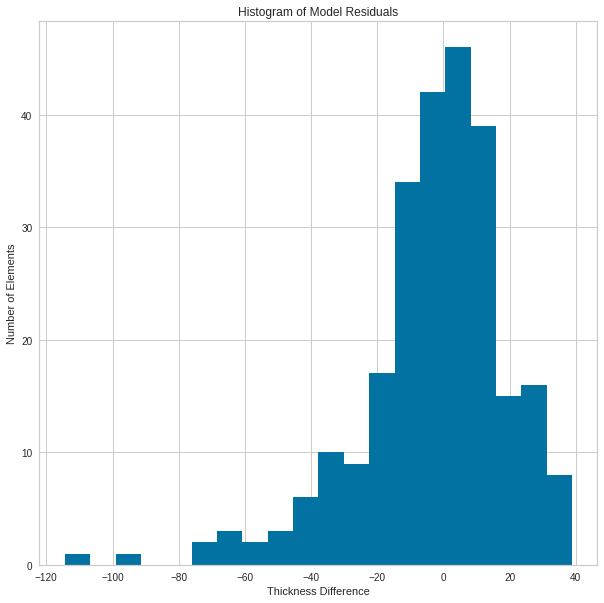

In [37]:
plt.figure(figsize = (10,10))
plt.hist(estimates.mean() - labels, 20)
plt.xlabel('Thickness Difference')
plt.ylabel('Number of Elements')
plt.title('Histogram of Model Residuals')
mean = (estimates.mean() - labels).mean()
med = (estimates.mean() - labels).median()
mode = (estimates.mean() - labels).mode()
# plt.title('Log Percent Difference of Edasi & Lipovsky and Farinotti Glacier Volume')
# plt.axvline(mean, color='k', linestyle='dashed', linewidth=1)
# # plt.text(mean, 'Mean: {:.2f}'.format(mean))

# plt.axvline(med, color='k', linestyle='dashed', linewidth=1)
# # plt.text(med, 'Median: {:.2f}'.format(med))
# plt.axvline(mode[0], color='k', linestyle='dashed', linewidth=1)
# # plt.text((mode[0]), 'Mode: ' + str(np.round(mode[0], 2)))